# Energy Load Forecasting

```{note}
These examples are originally from the [AI Explainability 360 Toolkit for Time-Series and Industrial Use Cases](https://ai-library-examples.github.io/aix4industries/books/intro.html#) book.
```

Accurate forecasting of expected energy load is identified as one of the highest leverage contribution areas of Machine/Deep Learning toward transitioning to a renewable-based electrical infrastructure. In this demo, we cover a use case on forecasting energy load using [hourly energy demand generation data](https://www.kaggle.com/datasets/nicholasjhana/energy-consumption-generation-prices-and-weather?resource=download).

This dataset is originally from [ENTSOE transparency platform](https://transparency.entsoe.eu/dashboard/show), and contains 4 years of hourly electrical consumption, coal consumption, effluent gas generation, hourly forecasted and actual energy demand, and energy pricing generation. For this demo, we only use the actual energy demand column (**total actual load**). Though energy load forecast is affected by external factors like weather, and unit pricing, the load data exhibits a strong diurnal pattern and autoregressive structure. So, we treat the forecasting problem as univariate forecasting. The model predicts the next 12-hour energy load from the last three days' data.

TrustyAI will use aix360's [Time Series Individual Conditional Expectation (TSLimeExplainer)](https://github.com/Trusted-AI/AIX360/blob/master/aix360/algorithms/tslime/tslime.py) implementation to explain the energy load forecaster's sensitivity, *i.e.*, how the model forecast is impacted by the input. Further, we analyze the impact of the input time series in terms of time series data statistics.

#### Time Series Individual Conditional Expectation
`TSICEExplainer` is a model agnostic, black box forecaster explainer and provides local explanations for time series data. This algorithm adapts traditional Individual Conditional Expectation plot to time series modality. Timeseries data is highly correlated. Many algorithms often use features derived from the timeseries for forecasting. But these features cannot be changed independently. The TSICE relies on temporally focused sampling method (via timeseries perturbation) to explore this feature space and establishes the connection from this feature space to the model output.

### Imports

In [1]:
import os
import warnings
from typing import Union
# to suppress unrelated tensorflow warnings while importing aix360.datasets
warnings.filterwarnings("ignore")
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

import numpy as np 
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
plt.style.use('../styles/material_rh.mplstyle')

from trustyai.explainers.extras.tsice import TSICEExplainer

### Load Dataset

The dataset is available in [here](../data/energy_dataset.csv.zip)[^1]. 

The data has `NaN` values and so, imputing using `interpolate` to have uniform frequency.

[^1]: Alternatively, you download the dataset from [Kaggle](https://www.kaggle.com/datasets/nicholasjhana/energy-consumption-generation-prices-and-weather) manually.

In [2]:
energy_df = pd.read_csv('../data/energy_dataset.csv.zip', header=0, index_col=0)
energy_df.index = pd.to_datetime(energy_df.index, utc=True)
energy_df = energy_df.sort_index()
energy_df.index.freq = pd.infer_freq(energy_df.index)

total_energy_col = 'total load actual'
energy_df[total_energy_col] = energy_df[total_energy_col].interpolate(method='time', axis=0)

energy_df[total_energy_col].describe()

count    35064.000000
mean     28698.281385
std       4575.828854
min      18041.000000
25%      24807.000000
50%      28902.000000
75%      32194.250000
max      41015.000000
Name: total load actual, dtype: float64

## Plot the dataset

Plot energy load from Feb 2015.

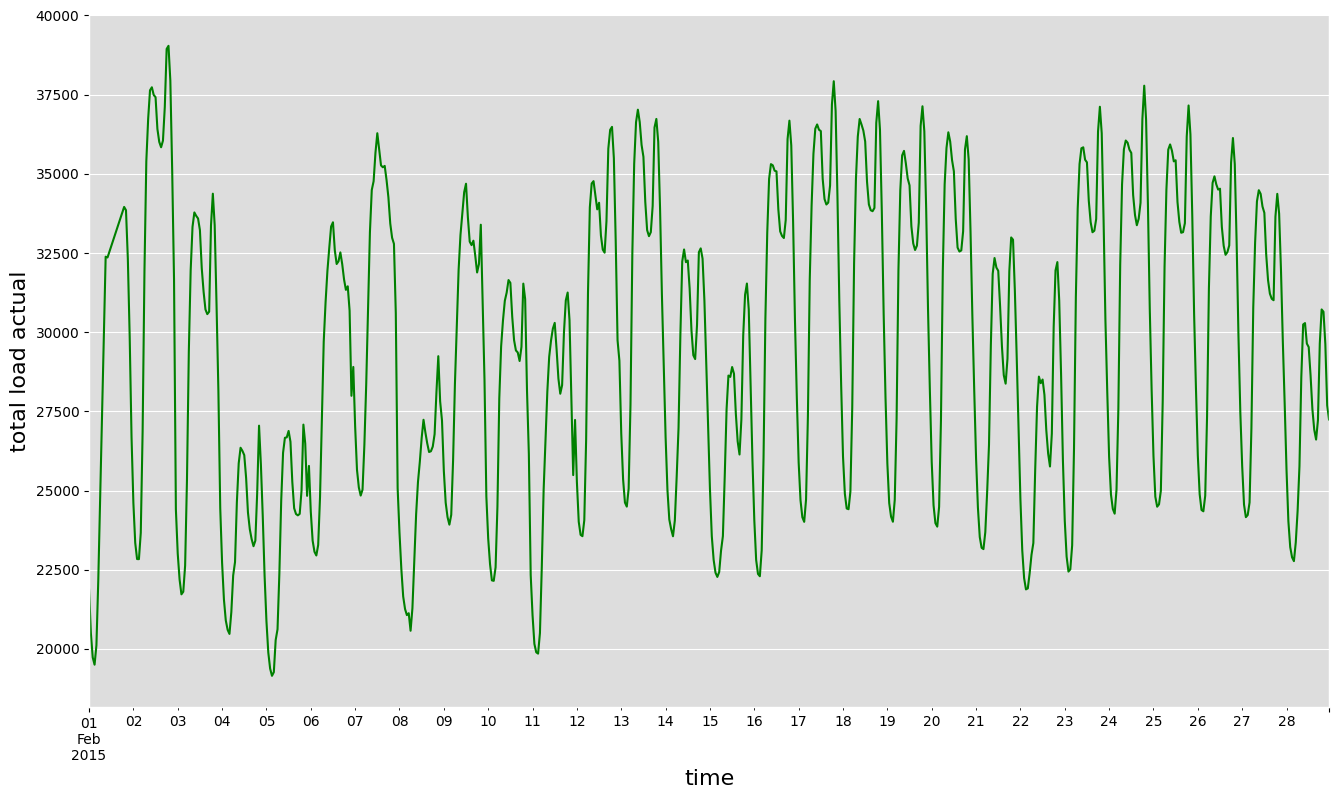

In [3]:
_, ax = plt.subplots(1, 1)
_ = energy_df[total_energy_col]['2015-02-01':'2015-02-28'].plot(color='green', ax=ax)
_ = ax.set_xlabel('time', fontsize=16)
_ = ax.set_ylabel(total_energy_col, fontsize=16)

### Data Preprocessing
Prepare the data for the model by running a 72-hour sliding window on each partition. And extract the history input (72-hour) and forecast (12-hour) pair at the same time. 

In [4]:
history_length, lookahead = 72, 12
x = energy_df[total_energy_col].values
t_x = list(energy_df[total_energy_col].index)
data_len = x.shape[0]

X_all = list()
t_all = list()

for i in range(data_len - history_length - lookahead):
    x_seg = x[i:i+history_length + lookahead]
    if (np.max(x_seg) - np.min(x_seg)) > 2000:
        X_all.append(x_seg)
        t_all.append(t_x[(i+history_length):(i+history_length + lookahead)])
X_all = np.array(X_all)[..., np.newaxis]

X, y = X_all[:, :history_length], X_all[:, history_length:]

## Train Test Split
Train a Convolution Network based (Dilated Convolution Network) deep learning model, that forecast the next 12 hours' energy demand by looking at the last 3 days (72 hours) energy consumption. For the model training purposes, we split the data into three parts, (1) training (80%), (2) validation (10%), and (3) test (10%). 

In [5]:
n_data = X.shape[0]
train_len = int(0.8 * n_data)
validation_len = int(0.9 * n_data)

X_train, y_train = X[:train_len], y[:train_len] 
X_val, y_val = X[train_len:validation_len], y[train_len:validation_len]
X_test, y_test = X[validation_len:], y[validation_len:]
t_val = t_all[validation_len:]

## Robust Scaling of the data
Apply robust quantile scaling *i.e.*, scale the data using lower(1%) and upper(99%) quantile values. As a result, forecasted values are scaled as well.


In [6]:
class RobustQuantileScaler:
    def __init__(self):
        self.data_lo = None
        self.data_hi = None

    def transform(self, data, y=None):
        self.data_lo, self.data_hi = np.quantile(data, q=(0.01, 0.99), axis=1, keepdims=True)
        data_X = (data - self.data_lo) / np.maximum((self.data_hi - self.data_lo), 1)

        data_y = None
        if y is not None:
            data_y = (y - self.data_lo) / np.maximum((self.data_hi - self.data_lo), 1)

        return data_X, data_y
    
    def inverse_transform(self, data):
        return data * (self.data_hi - self.data_lo) + self.data_lo

X_train, y_train = RobustQuantileScaler().transform(X_train, y_train)
X_val, y_val = RobustQuantileScaler().transform(X_val, y_val)

X_input_scaler = RobustQuantileScaler()
X_in, _ = X_input_scaler.transform(X_test[:3000])

### Load Pre-Trained Model
Build a deep neural network model composed of dilated causal convolution layers followed by dense layers. And it uses residual connection between the convolution layers. Outputs from the convolution layers are concatenated, and then further passed to the dense FC (fully connected) layer to produce the forecast. The model is configured for a fixed length input of `history_length` (=72) size and produce a fixed length forecast of length `lookahead` (=12).

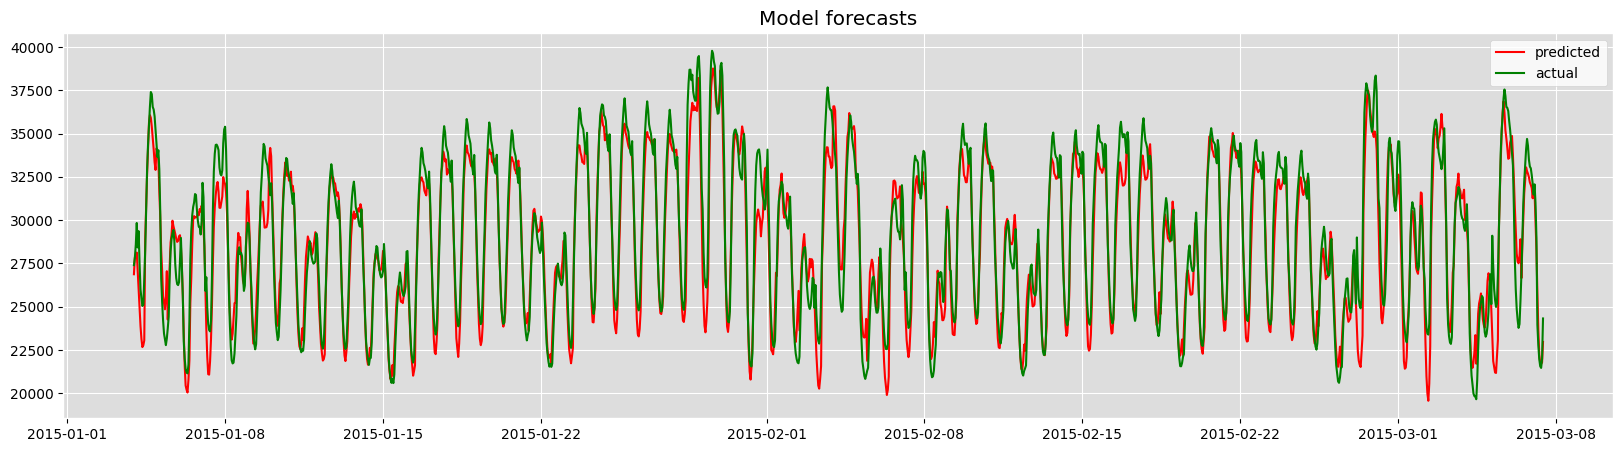

In [7]:
d_input = tf.keras.layers.Input((history_length, 1))
x = d_input

x1 = tf.keras.layers.Conv1D(16, kernel_size=5, padding='causal', activation='relu')(x)
x2 = tf.keras.layers.Conv1D(16, kernel_size=5, dilation_rate=2, padding='causal', activation='relu')(x1 + x)
x3 = tf.keras.layers.Conv1D(16, kernel_size=5, dilation_rate=4, padding='causal', activation='relu')(x2 + x1)
x4 = tf.keras.layers.Conv1D(16, kernel_size=5, dilation_rate=4, padding='causal', activation='relu')(x3 + x2)
x = tf.concat([x1, x2, x3, x4], axis=-1)
x = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(1, activation='gelu'))(x)

x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(16, activation='elu')(x)
x = tf.keras.layers.Dense(lookahead, activation='linear')(x)
x_out = tf.keras.layers.Reshape((lookahead, 1))(x)

model = tf.keras.Model(d_input, x_out)
model.compile(loss="mse", optimizer='adam')

if not os.path.exists('energy_load_forecast.h5'):
    callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=5)
    history = model.fit(X_train, y_train, 
                        validation_data=[X_val[:100], y_val[:100]], 
                        batch_size=256, 
                        epochs=500, 
                        verbose=0, 
                        callbacks=[callback])
    model.save_weights('energy_load_forecast.h5', save_format="h5")
else:
    model.load_weights('energy_load_forecast.h5')

class ForecastingPipeline:
    def __init__(self, model):
        self.model = model
    
    def __call__(self, x):
        if x.shape[0] == 1:
            x = x.T
        
        if len(x.shape) != 3:
            x = x[np.newaxis, ...]

        x_in_scaler = RobustQuantileScaler()
        x_in, _ = x_in_scaler.transform(x)
        y = self.model.predict(x_in, verbose=0)
        y = x_in_scaler.inverse_transform(y)
        return y[..., 0]

forecast = ForecastingPipeline(model)

y_out = forecast(X_test[:3000])
i_start, i_end = 0, 1500

y_true = np.concatenate([y_test[_] for _ in range(i_start, i_end, lookahead)], axis=0)
y_pred = np.concatenate([y_out[_] for _ in range(i_start, i_end, lookahead)], axis=0)
t_test =  np.concatenate([t_all[_] for _ in range(i_start, i_end, lookahead)], axis=0)

_ , ax = plt.subplots(1, 1, figsize=(20, 5))
ax.plot(t_test, y_pred, label='predicted', color='red')
ax.plot(t_test, y_true[:, 0], label='actual', color='green')
ax.legend()
plt.title("Model forecasts")
plt.show()


### Initializing TSICE Explainer
[TSICEExplainer](https://github.com/Trusted-AI/AIX360/blob/master/aix360/algorithms/tsice/tsice.py) uses [TSPerturber](https://github.com/Trusted-AI/AIX360/blob/ef086583a1722b9a8714abc1ac6e8eeb9e3e3a2e/aix360/algorithms/tsutils/tsperturbers/tsperturber.py#L52) for generating perturbed/simulated data and [TSFeatures](https://github.ibm.com/srom/aix360-internal/blob/master/aix360/algorithms/tsutils/tsfeatures/tsfeatures.py) ([Latest](https://github.ibm.com/srom/aix360-internal/blob/master/aix360/algorithms/tsutils/tsfeatures/latest_features.py)/[Range](https://github.ibm.com/srom/aix360-internal/blob/master/aix360/algorithms/tsutils/tsfeatures/range_features.py) Feature) to derive time series structural features for further analysis. The `TSICEExplainer` explains the trend in the model forecast change by varying the selected part of the time series.

Available perturbers are ["block-bootstrap"](https://github.com/Trusted-AI/AIX360/blob/master/aix360/algorithms/tsutils/tsperturbers/block_bootstrap_perturber.py)(default), ["frequency"](https://github.com/Trusted-AI/AIX360/blob/master/aix360/algorithms/tsutils/tsperturbers/frequency_perturber.py), ["moving_average"](https://github.com/Trusted-AI/AIX360/blob/master/aix360/algorithms/tsutils/tsperturbers/moving_average_perturber.py), and ["shift"](https://github.com/Trusted-AI/AIX360/blob/master/aix360/algorithms/tsutils/tsperturbers/ts_shift_perturber.py). Available aggregation metrics (stats) are "median", "mean", "min", "max", "std", "range", "intercept", "trend", "rsquared", "max_variation". `explanation_window_start` and `explanation_window_length` are used to select observation window to be explained.


In [8]:
tsice_explainer = TSICEExplainer(forecast, 
                             input_length=history_length, 
                             forecast_lookahead=lookahead,
                             n_variables=1,
                             perturbers=[
                                  dict(type="block-bootstrap", 
                                       window_length=5, 
                                       block_length=5, 
                                       block_swap=2),
                              ],
                             features_to_analyze=['std', 'mean', 'max_variation', 'trend'],
                             explanation_window_length=12)

### Compute TSICE Explanation
`TSICEExplainer` produces a local explanation, for the current instance. The local explanation can be produced via the `explain_instance` API call. For the explanation generation `TSICEExplainer` carries out time series sampling. For detailed analysis, we often required large number of samples. Specify number of samples to use for the explanation generation using `n_perturbation`.

The following cells demonstrate the usage of TSICE to explain impact of latest part of the input timeseries. 

In [9]:
tsice_explanation = tsice_explainer.explain(energy_df[[total_energy_col]]['2017-05-11':'2017-05-13'], n_perturbations=100)

### Plot TSICE Explanation


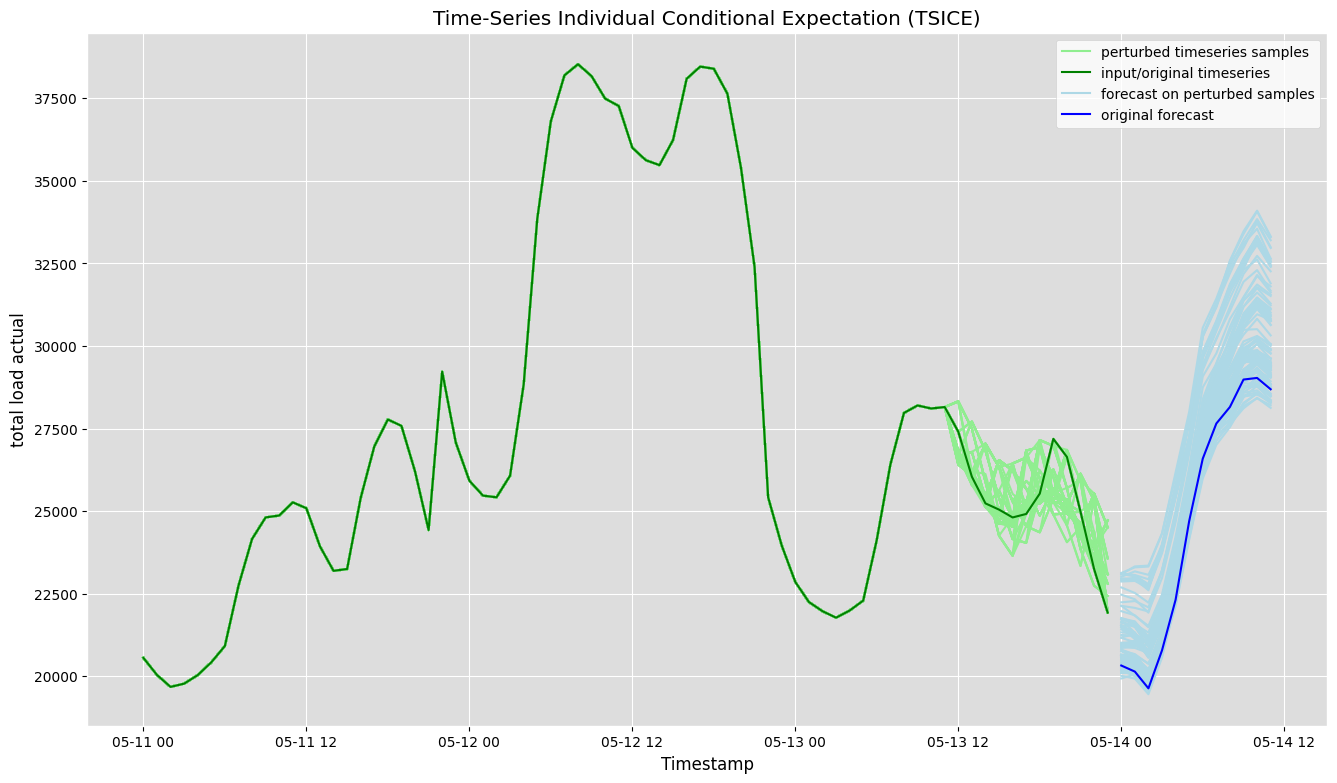

In [10]:
tsice_explanation.plot_forecast("total load actual")


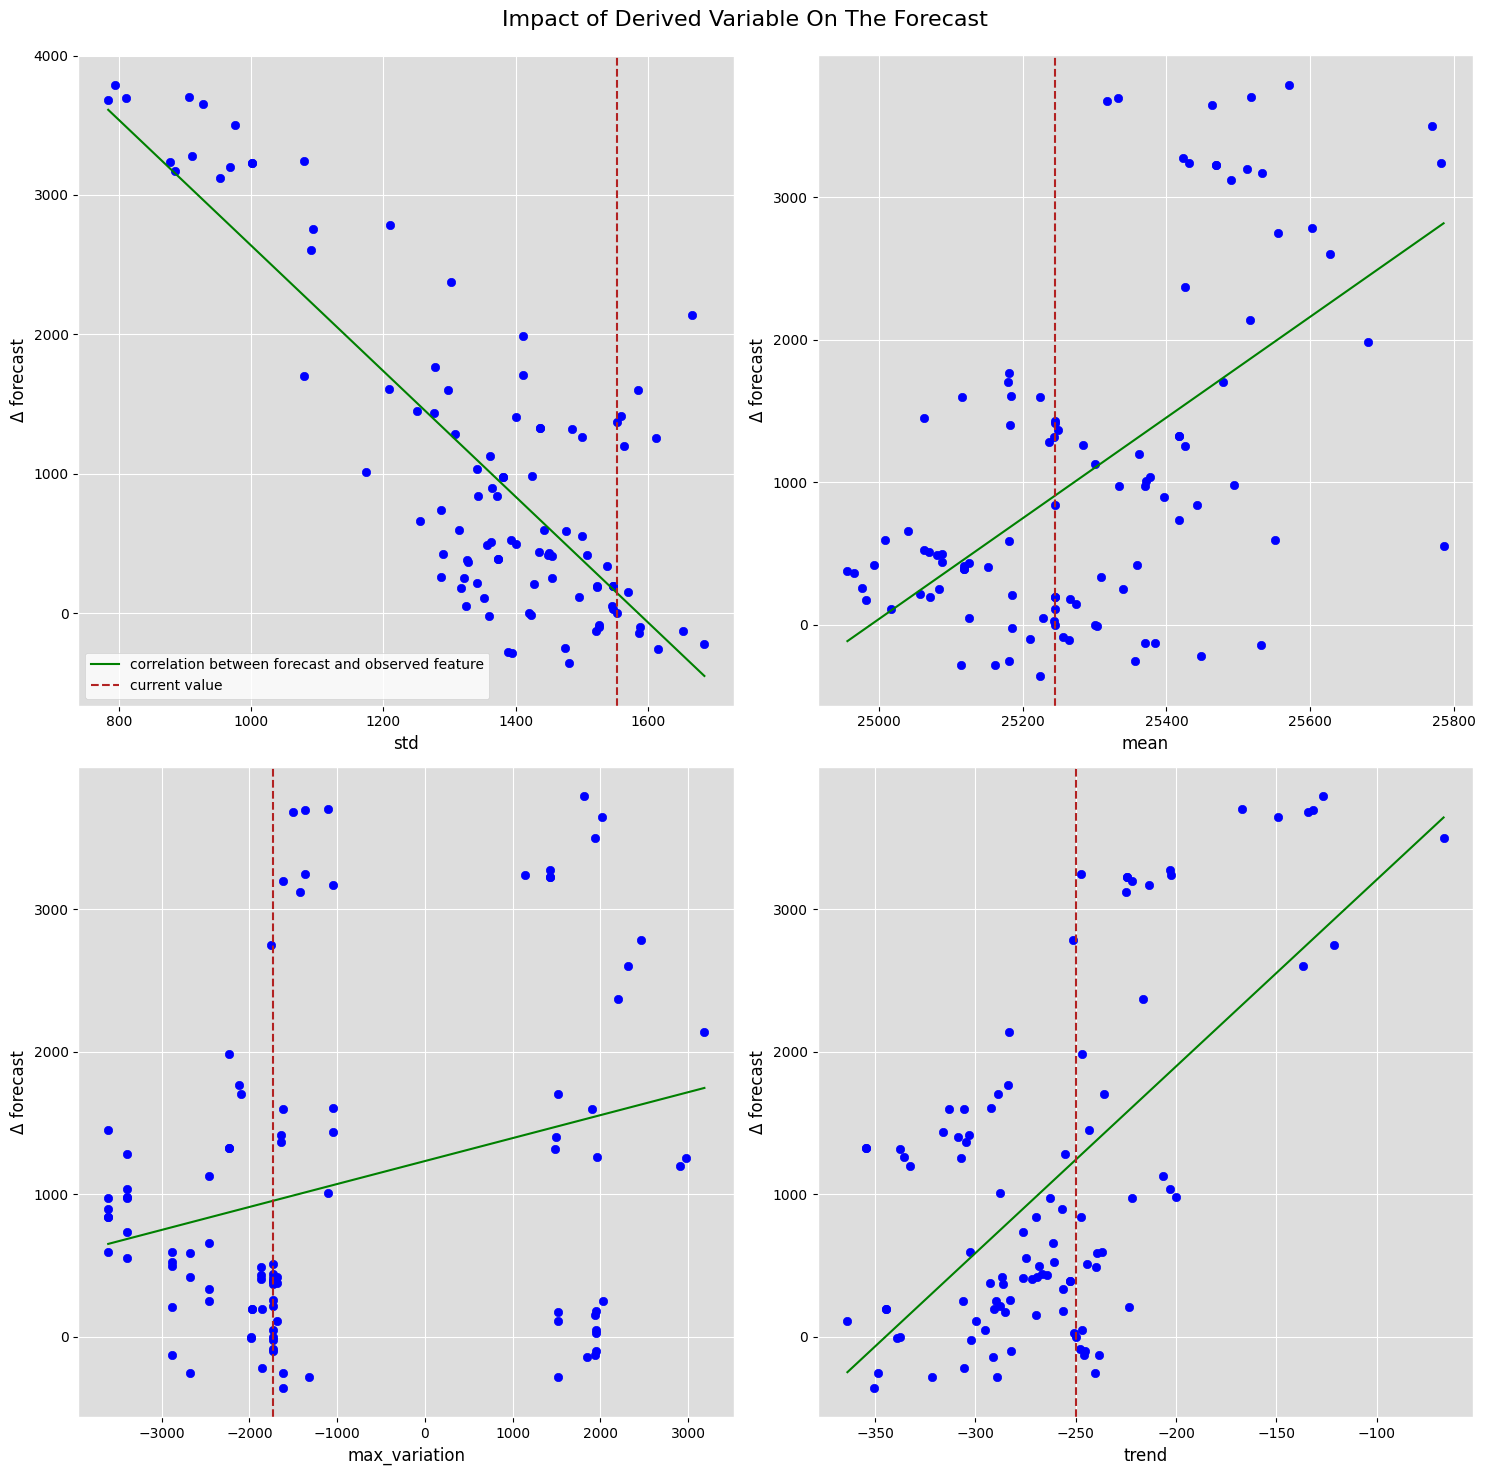

In [11]:
tsice_explanation.plot_impact()